In [1]:
%load_ext autoreload
%autoreload 2

# PCA analisis

This notebook performs a PCA analysis of the dropout-filtered data.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
font = {'family' : 'sans-serif',
        'size'   : 15}
matplotlib.rc('font', **font)
from local_utils import get_mean, get_mean2, pca_comp, pca_variance
import seaborn as sns

Dropout filtering has provided us with a dataframe with 28603 genes. The dataframe df_nonzero_means contains the means of the replicates for each sample.

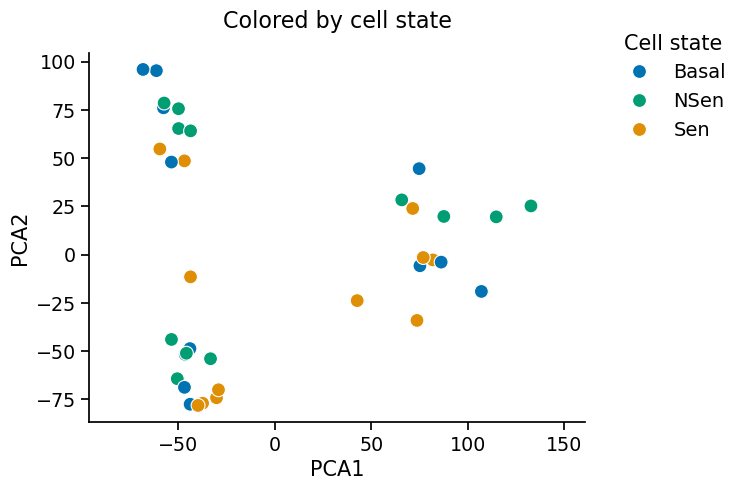

In [3]:
df_nonzero_means = pd.read_csv("df_nonzero_means.csv", sep="\t")

df_nonzero_means.columns = df_nonzero_means.columns.str.replace('_mean','')

pca_df = pca_comp(df_nonzero_means, sorting='Cell state')

plt.figure()
with sns.plotting_context("notebook", font_scale=1.25): #style cound be changed to "talk" or "notebook"
    ax = sns.scatterplot(x="PCA1", y="PCA2",
                data=pca_df, 
                hue="Cell state",                   
                s=100,
                palette = sns.color_palette(['#0173b2','#029e73', '#de8f05'])) #from colorblind palette in order: blue, green, orange
    plt.xlabel("PCA1")
    plt.ylabel("PCA2")
    plt.title("Colored by cell state", pad = 18, fontsize = 16)
    
sns.move_legend(ax, "upper right", bbox_to_anchor=(1.32, 1.1), frameon = False, title = "Cell state", fontsize = 14)
  
# Hide the right and top spines
ax.spines[['right', 'top']].set_visible(False) #--> adjust to remove lines in figures

plt.gca().set_aspect('equal', 'datalim')

plt.savefig('figures/fig_PCA_dropout_cell_state.pdf', dpi = 500, bbox_inches = 'tight',  transparent=True)

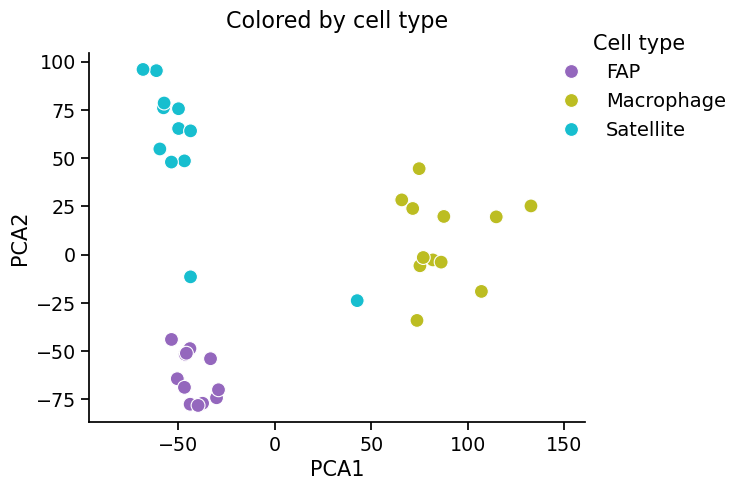

In [4]:
pca_df = pca_comp(df_nonzero_means, sorting='Cell type')

plt.figure()
with sns.plotting_context("notebook", font_scale=1.25): #style cound be changed to "talk" or "notebook"
    ax = sns.scatterplot(x="PCA1", y="PCA2",
                data=pca_df, 
                hue="Cell type",                   
                s=100,
                palette = sns.color_palette(['#9467bd','#bcbd22', '#17becf'])) #from colorblind palette in order: blue, green, orange
    plt.xlabel("PCA1")
    plt.ylabel("PCA2")
    plt.title("Colored by cell type", pad = 18, fontsize = 16)
    
sns.move_legend(ax, "upper right", bbox_to_anchor=(1.32, 1.1), frameon = False, title = "Cell type", fontsize = 14)
  
# Hide the right and top spines
ax.spines[['right', 'top']].set_visible(False) #--> adjust to remove lines in figures

plt.gca().set_aspect('equal', 'datalim')

plt.savefig('figures/fig_PCA_dropout_cell_type.pdf', dpi = 500, bbox_inches = 'tight',  transparent=True)

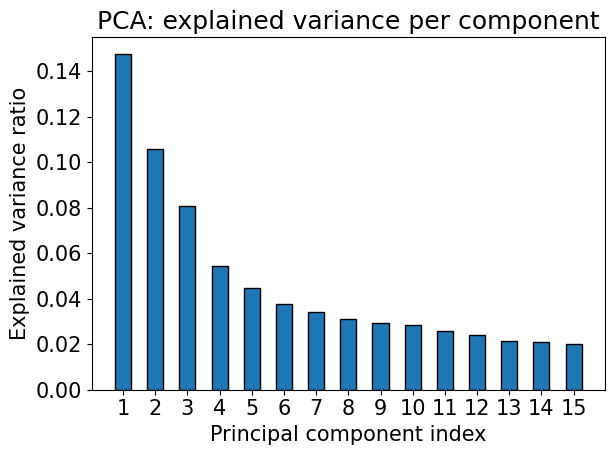

In [5]:
[ind_variance, loadings] = pca_variance(df_nonzero_means)
n_features = len(ind_variance)

plt.figure()

plt.bar(range(1, 16), ind_variance[:15], align='center', edgecolor='black', width=0.5)

plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.title('PCA: explained variance per component')
plt.xticks(range(1, 16))

plt.tight_layout()
plt.savefig('figures/fig_pca_variance_dropout.pdf')
plt.show()

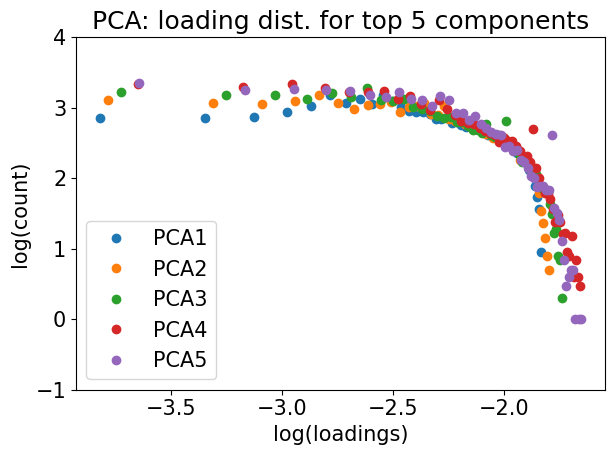

In [6]:
plt.figure()

ind = 1
for loads in loadings[:5]:
    [hist, bin_edges] = np.histogram(np.abs(loads),bins=50)
    bin_centers = bin_edges[0:-1]+np.diff(bin_edges)*0.5
    plt.plot(np.log10(bin_centers+1e-6),np.log10(hist+1e-6),'o',label='PCA%i'%ind)
    ind = ind+1

plt.xlabel('log(loadings)')
plt.ylabel('log(count)')
plt.ylim([-1,4])
plt.title('PCA: loading dist. for top 5 components')
plt.legend()

plt.tight_layout()
plt.savefig('figures/fig_load_dist_dropout.pdf')
plt.show()

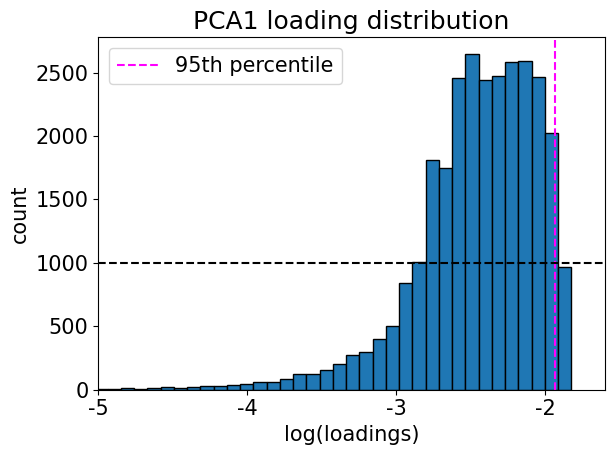

In [7]:
plt.figure()

plt.hist(np.log10(np.abs(loadings[0])),bins=50,edgecolor='black')
plt.axvline(np.log10(np.quantile(np.abs(loadings[0]),0.95)),color='magenta',linestyle='--',label='95th percentile')
plt.axhline(1000,color='black',linestyle='--')

plt.xlabel('log(loadings)')
plt.ylabel('count')
plt.title('PCA1 loading distribution')
plt.xlim([-5,-1.6])
plt.xticks([-5,-4,-3,-2],[-5,-4,-3,-2])
plt.legend()

plt.tight_layout()
plt.savefig('figures/fig_load_dist_PCA1_dropout.pdf')
plt.show()

We now generate the loading plot:

In [8]:
geneids = df_nonzero_means.iloc[:,0].values

lut = pd.read_csv("geneID_ens_symbol.csv", sep="\t")
lut = lut.drop('Unnamed: 0', axis=1)
ecfs_genes = ['Fabp3','Lncpint','Pcnp','Luc7l3','AI427809','Cd59a']
ecfs_ids = []
for i, egene in enumerate(ecfs_genes):
    ecfs_ids.append(lut[lut['symbol']==egene]['ensID'].to_string(index=False))

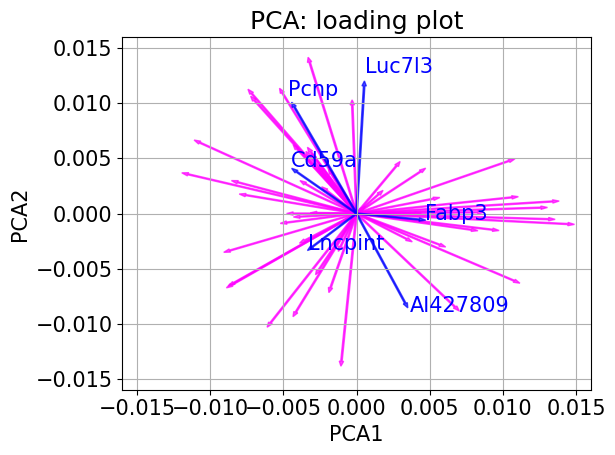

In [9]:
plt.figure()
plt.xlabel('PCA1')
plt.ylabel('PCA2')

rng = np.random.default_rng(12345)
ivec = rng.choice(len(geneids),50)
for i in ivec:
    # Add an arrow representing the variable on the new axis
    plt.arrow(0, 0,
              loadings[0,i],
              loadings[1,i],
              color='magenta',
              alpha=0.7, 
              width=1e-4
             )

for feature in ecfs_ids:
    i = np.where(geneids == feature)[0][0]
    genename = lut[lut['ensID']==feature]['symbol'].to_string(index=False)
    # Add the name of the variable near the arrow
    plt.annotate(genename, # variable name
                 (loadings[0,i]*1.1,
                  loadings[1,i]*1.1),
                 color='blue')
    # Add an arrow representing the variable on the new axis
    plt.arrow(0, 0,
              loadings[0,i],
              loadings[1,i],
              color='blue',
              alpha=0.7, 
              width=1e-4
             )
    
plt.xlim(-0.016,0.016)
plt.ylim(-0.016,0.016)
plt.title('PCA: loading plot')
plt.grid(True)

plt.tight_layout()
plt.savefig('figures/fig_loading_plot_dropout.pdf')
plt.show()